In [4]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [5]:
#trasformo le date e i numeri
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [6]:
#metto il campo 'Data' come indice
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,2632
2015-01-02,2182
2015-01-03,2215
2015-01-04,2264
2015-01-05,2301


In [7]:
#creo la time series
ts = df.Totale
ts.head()

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
Name: Totale, dtype: int64

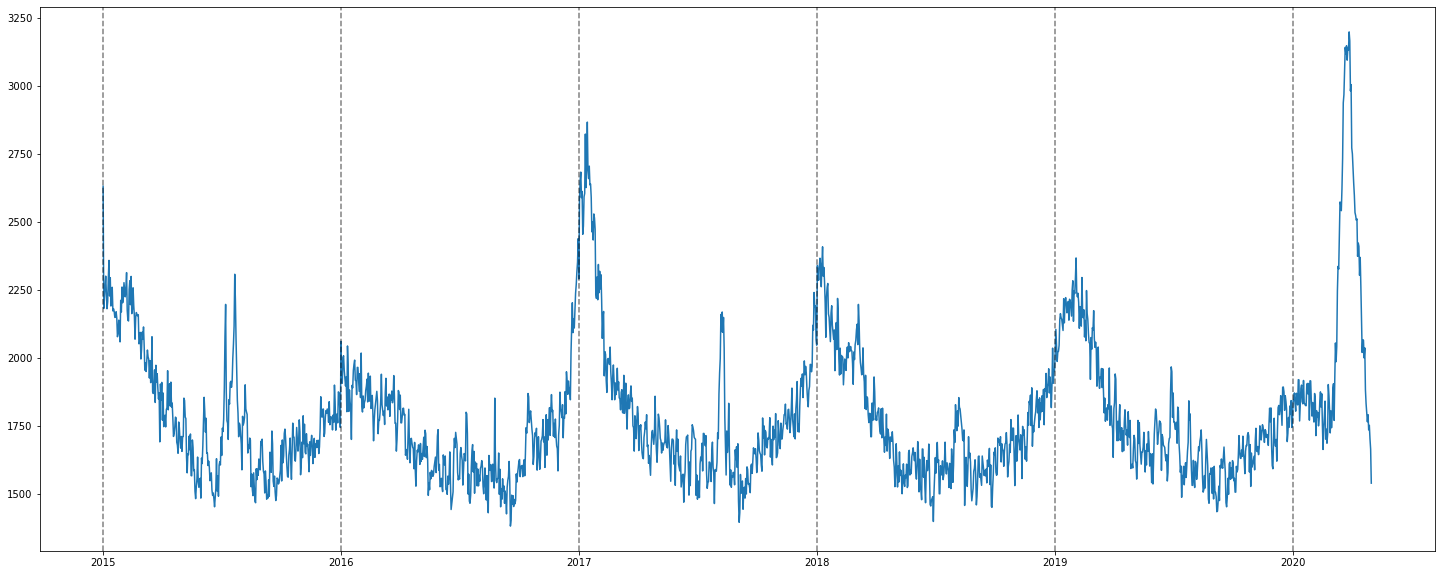

In [8]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

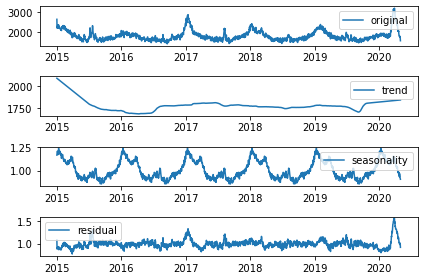

In [9]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

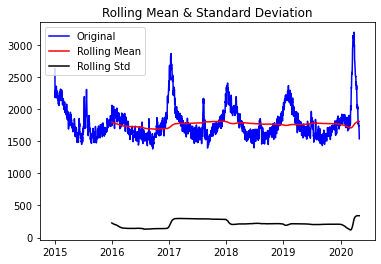

Results of Dickey-Fuller Test:
Test Statistic                -6.969065e+00
p-value                        8.760107e-10
#Lags Used                     0.000000e+00
Number of Observations Used    1.946000e+03
Critical Value (1%)           -3.433715e+00
Critical Value (5%)           -2.863026e+00
Critical Value (10%)          -2.567561e+00
dtype: float64
X is stationary


In [11]:
#verifico che il trend sia stazionario
test_stationarity(ts)

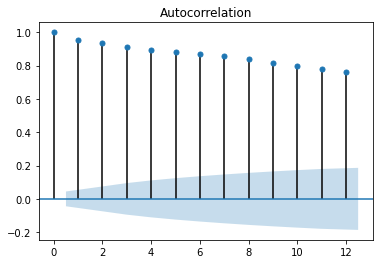

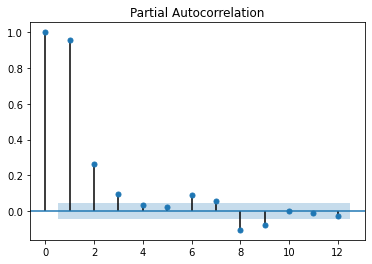

In [12]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [13]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

# periodo dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

# periodo dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]

#trend COVID: periodo dal 01-01-2020 al 30-04-2020
trend_covid = ts[test_end + timedelta(days=1): covid_end]

In [24]:
from arch import arch_model
model = arch_model(train, mean='AR', vol='GARCH', p=11, q=9)
model_fit = model.fit()

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.146e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     24,   Neg. LLF: 11446.669600586803
Iteration:      2,   Func. Count:     47,   Neg. LLF: 11492.311915264116
Iteration:      3,   Func. Count:     71,   Neg. LLF: 12408.160512965303
Iteration:      4,   Func. Count:     95,   Neg. LLF: 16604.148825140917
Iteration:      5,   Func. Count:    119,   Neg. LLF: 11398.654315765969
Iteration:      6,   Func. Count:    143,   Neg. LLF: 12445.376116757827
Iteration:      7,   Func. Count:    167,   Neg. LLF: 11271.399399807078
Iteration:      8,   Func. Count:    191,   Neg. LLF: 11399.446620133673
Iteration:      9,   Func. Count:    215,   Neg. LLF: 11257.647236168537
Iteration:     10,   Func. Count:    238,   Neg. LLF: 11256.62379076742
Iteration:     11,   Func. Count:    261,   Neg. LLF: 11256.830142779985
Iteration:     12,   Func. Count:    285,   Neg. LLF: 11268.241345650495
Iteration:     13,   Func. Count:    310,   Neg. LLF: 11256.022883716942
Iteration:     14,   Func. Count:    334,   Neg. LLF

In [25]:
print(model_fit.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                 Totale   R-squared:                      -0.190
Mean Model:                        AR   Adj. R-squared:                 -0.190
Vol Model:                      GARCH   Log-Likelihood:               -11238.2
Distribution:                  Normal   AIC:                           22520.4
Method:            Maximum Likelihood   BIC:                           22640.9
                                        No. Observations:                 1765
Date:                Tue, Sep 15 2020   Df Residuals:                     1743
Time:                        11:04:41   Df Model:                           22
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const       1669.8947      7.498    222.708      0.000 [1.

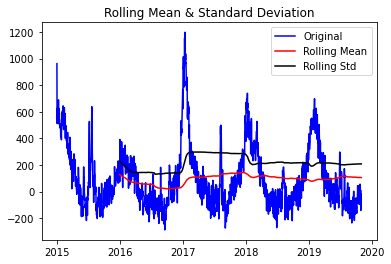

Results of Dickey-Fuller Test:
Test Statistic                   -3.703312
p-value                           0.004067
#Lags Used                       15.000000
Number of Observations Used    1749.000000
Critical Value (1%)              -3.434094
Critical Value (5%)              -2.863194
Critical Value (10%)             -2.567651
dtype: float64
X is not stationary


In [26]:
residuals = model_fit.resid
test_stationarity(residuals)

In [27]:
# ARCH model: residui modello non stazionari